In [1]:
import sys
sys.path.append('Classifier')

In [2]:
from data_loader import get_task1_conver, get_task2_conver
from utils import dump_jsonl, load_jsonl


import pickle

def load_shap_values(filepath):
  with open(filepath, 'rb') as fin:
    obj = pickle.load(fin)
  return obj

def save_shap_values(filepath, obj):
  with open(filepath, 'wb') as fin:
    pickle.dump(obj, fin)

In [3]:
import pandas as pd

In [4]:
from pythainlp.tokenize import word_tokenize
import numpy as np

In [5]:
import json
with open("words.json", encoding="utf-8") as fin:
    raw = json.load(fin)
    thaidict_royal = set()
    for k in raw:
        thaidict_royal.update(raw[k])

In [6]:
lexicons_arr = load_jsonl("lexicons.jsonl")

Loaded 25573 records from lexicons.jsonl


In [7]:
from collections import defaultdict
tags = set()
lexicons = {}
lexicons_keys = defaultdict(list)

for key, values  in lexicons_arr:
    if len(key) <= 1:
        continue
        
    key = key.lower()
    if key.endswith("rep"):
        key = key.replace("rep", "")
        
    w = word_tokenize(key)
    
    lexicons_keys[w[0]].append(key)
    
    tag = [t for t in values["tags"] if not t.startswith("cat:")]
    lexicons[key] = tag
    tags.update(tag)

In [8]:
metric_names = {
    "Reference" : {
        "all": "All words",
#         "pertoken": "Average per token"
    },
    "Linguistic Complexity" : {
#         "nunique": "Vocabulary size",
        "nthai": "Thai words",
        "nnotthai": "Non-Thai words",
        "nlongword": "Long words",
        "ndict": "Dictionary words",
        "transliterated": "Transliteration",
    },
    "Pronoun": {
        "pronoun": "All pronoun",
        "pronoun_1st": ">> 1st person pronoun",
        "pronoun_2nd": ">> 2nd person pronoun",
        "pronoun_3rd": ">> 3rd person pronoun",
        "pronoun_misspelling": ">> Pronoun in non-standard spelling",
    },
    
    "Sentence-ending Particles": {
        "particles": "All particles",
        "particles_SARP": ">> Socially-related particles",
        "particles_notSARP": ">> Non-socially-related particles",
        "particles_misspelling": ">> Particle in non-standard spelling",
    },
    
    "Sentiment-related": {
        "sentiment": "Sentiment words",
        "sentiment_positive": ">> Positive words",
        "sentiment_negative": ">> Negative words",
    },
    
    "Spelling Variation": {
        "misspelling": "All spelling variation",
        "misspelling_common": ">> Common misspelt words",
        "misspelling_intention": ">> Morphophonemic variation",
        "misspelling_shorten": ">> Simplified variation",
        "nrepeat": ">> Repeated characters",
        "nemoji": ">> Emoji",
        "abbr": "Abbreviation",
#         "slang": "Slang",
        "swear": "Swear words"
    }
}

In [9]:
def map_token_2_words(words, shap_tokens, debug=False):
    tokens = [w for w, _ in  shap_tokens]
    values = np.array([v for _, v in  shap_tokens])
    
    idxs = []
    sidx = 0
    windows = 10
        
    newwords = []
    newtokens = []
    newvalues = []
    
    
    widx = 0
    w = ""
    while widx < len(words):
        w += words[widx]
        if sidx >= len(tokens):
#             print(newwords)
#             assert(False)
            break
            
#         print(widx, w, sidx, tokens[sidx])
#         break
        s = ""
        matched = False
        for tidx in range(sidx, min(sidx+windows, len(tokens))):
            s += tokens[tidx]
            if s==w:
                matched = True
                break
                
        if matched:
            if debug:
                print("MATCHED", w)
            idxs.append([sidx, tidx+1])
            newwords.append(w)
            newtokens.append("".join(tokens[sidx:tidx+1]))
            newvalues.append(values[sidx:tidx+1].sum())
            sidx = tidx+1
            w = ""
            widx += 1
            continue
        
        if debug:
            print("NOT MATCHED", w, s)
            
        if not s.startswith(w):
            sidx += 1
            w = ""
#             print("SKIP TOKEN")
            continue
        else:                
            widx += 1
#             print("MERGE WORDS")
            continue
            
    if debug:    
        print(newwords)
        print(newtokens)
    
    
    return newtokens, newvalues

def get_shap_lexicons(df, raw_shap_values):
    shap_lexicons = {}
    label_values = df["label"].unique()
    

    _tmp = raw_shap_values[:, :]
    shap_data = _tmp.data
    shap_values = _tmp.values

    for _, label in enumerate(label_values):
        feats = []
        for idx, row in df.iterrows():
            if row["label"]!=label:
                continue
            
            text = row["text"]
            words = word_tokenize(preprocess(row["text"]))
            words = [w.strip() for w in words if len(w.strip())>0]
            
            shap_tokens = [(w.strip(), v) for w,v in zip(shap_data[idx], shap_values[idx]) if len(w.strip())>0]
            shap_tokens = map_token_2_words(words, shap_tokens, debug=False)
            feats.append(shap_tokens)
        shap_lexicons[label] = feats
    return shap_lexicons

In [10]:
from pythainlp.util import countthai
import re 
import emoji

def get_lexicon_feats(token, ref_text):
    feats = ["all"]
    
    if token=="rep":
        feats.append("nrepeat")
        
    if token in lexicons_keys:
        for l in lexicons_keys[token]:
            if not ref_text.startswith(l):
                continue

            feats.extend(lexicons[l])
            
    if token in thaidict_royal:
        feats.append("ndict")
    
    if len(token) > 7:
        feats.append("nlongword")
    
    if countthai(token) < 50:
        nt = re.sub(r'\W+', '', token)
        if token not in ["usr", "sys", "rep"] and len(nt) > 0 and not nt.isnumeric():
            feats.append("nnotthai")
    else:
        feats.append("nthai")
    
    if "particles" in feats and "particles_SARP" not in feats:
        feats.append("particles_notSARP")
    
    if emoji.emoji_count(token) > 0:
        feats.append("nemoji")
    
    return feats


In [11]:
# def get_all_shap_feats(shap_lexicons):
#     output = {}
#     for label in shap_lexicons:
#         all_shap_feats = []
#         for tokens, values in shap_lexicons[label]:
#             shap_feats = defaultdict(list)
#             for tidx, (t, v) in enumerate(zip(tokens, values)):
#                 feats = get_lexicon_feats(t, "".join(tokens[tidx:]))
                    
#                 for f in feats:
#                     shap_feats[f].append(v)
            
#             shap_feats["pertoken"] = values
#             all_shap_feats.append(shap_feats)
            
#         mean_shap_feats = {}
#         for g in metric_names:
#             for m in metric_names[g]:
#                 values = []
#                 for feats in all_shap_feats:
#                     if m in feats:
#                         absum = np.sum(np.abs(np.array(feats[m])))
#                         values += [absum]
#                         #values.append(feats[m])
                
#                 if len(values)==0:
#                     mean_shap_feats[m] = (0, 0)
#                     continue
                    
#                 rms = np.mean(np.array(values))
#                 mean_shap_feats[m] = (rms, len(values))
        
#         output[label] = mean_shap_feats
#     return output

# def get_shap_feats(shap_lexicons):
#     output = {}
#     for label in shap_lexicons:
#         all_shap_feats = []
#         for tokens, values in shap_lexicons[label]:
#             # shap_feats is per conversation
#             shap_feats = defaultdict(list)
#             for tidx, (t, v) in enumerate(zip(tokens, values)):
#                 feats = get_lexicon_feats(t, "".join(tokens[tidx:]))
                    
#                 for f in feats:
#                     shap_feats[f].append(v)
            
# #             shap_feats["pertoken"] = sum(values)/len(values)
#             shap_feats["pertoken"] = values
#             all_shap_feats.append(shap_feats)
            
#         mean_shap_feats = {}
#         for g in metric_names:
#             for m in metric_names[g]:
#                 values = []
#                 for feats in all_shap_feats:
#                     if m in feats:
#                         values += feats[m]
                
#                 if len(values)==0:
#                     mean_shap_feats[m] = (0, 0)
#                     continue
                    
#                 values = np.array(values)
#                 rms = np.sqrt(np.mean(values**2))
#                 mean_shap_feats[m] = (rms, len(values))
        
#         output[label] = mean_shap_feats
#     return output

In [12]:
from collections import defaultdict
from pythainlp.tokenize import word_tokenize
import itertools
from tqdm import tqdm

In [13]:
from itertools import groupby
from data_loader import preprocess

def run_preprocess(train, val, test):
    train["text"] = train["text"].apply(preprocess)
    val["text"] = val["text"].apply(preprocess)
    test["text"] = test["text"].apply(preprocess)
    return train, val, test

In [14]:
def run_lexicons(df, shap_path):
    train, val, test = df
    train["split"] = "train"
    val["split"] = "val"
    test["split"] = "test"

    df = pd.concat([train, test, val])
    shap_values = load_shap_values(shap_path)

    assert(len(df)==len(shap_values))
    
    shap_lexicons = get_shap_lexicons(df, shap_values)
    shap_feats = get_shap_feats(shap_lexicons)
    all_shap_feats = get_all_shap_feats(shap_lexicons)
    
    return shap_feats, all_shap_feats

In [15]:
# import matplotlib.pyplot as plt
# from collections import defaultdict
    
# def get_avg_shap_by_lexicons(reformatted_shap_values):
    
    
#     shap_by_lexicons = defaultdict(list)
#     for cat in reformatted_shap_values:
#         for words, shp_values in reformatted_shap_values[cat]:
#             shp_values = np.array(shp_values)
#             abs_shp_values = np.abs(shp_values)
#             mn = min(abs_shp_values)
#             mx = max(abs_shp_values)

# #             normed_shp_values = (abs_shp_values-mn)/(mx-mn)
#             normed_shp_values = abs_shp_values/sum(abs_shp_values)

#             for w, s in zip(words, normed_shp_values):
#                 shap_by_lexicons[w].append(s)

#     avg_shap_by_lexicons = {}
#     for w in shap_by_lexicons:
#         values = shap_by_lexicons[w]
#         if len(values) > 10 and w not in ["usr", "sys"]:
#             avg_shap_by_lexicons[w] = np.mean(values)
    
#     avg_shap_by_lexicons = dict(sorted(avg_shap_by_lexicons.items(), key=lambda item: -item[1]))
#     return avg_shap_by_lexicons

# v1 = get_avg_shap_by_lexicons(reformatted_shap_values)
# # v1

In [16]:
# def get_avg_annoated_score_by_lexicons(reformatted_shap_values, label_fn):
    
#     score_by_lexicons = defaultdict(list)
#     for cat in reformatted_shap_values:
#         score = label_fn(cat)
#         for words, _ in reformatted_shap_values[cat]:
#             for w in words:
#                 score_by_lexicons[w].append(score)

#     avg_score_by_lexicons = {}
#     for w in score_by_lexicons:
#         values = score_by_lexicons[w]
#         if len(values) > 10 and w not in ["usr", "sys"]:
#             avg_score_by_lexicons[w] = np.mean(values)
    
#     avg_score_by_lexicons = dict(sorted(avg_score_by_lexicons.items(), key=lambda item: -item[1]))
#     return avg_score_by_lexicons

# v2 = get_avg_annoated_score_by_lexicons(reformatted_shap_values, closeness_label_fn)

In [17]:
# from scipy import stats
# def cal_spearman_corr(v1, v2):
#     words = set(v1.keys()).union(set(v2.keys()))
#     feats_by_words = {}
#     for w in words:
#         feats_by_words[w] = get_lexicon_feats(w, w)
    
#     data = []
#     for g in metric_names:    
#         for m in metric_names[g]:
#             X1 = []
#             X2 = []
#             for w in words:
#                 feats = feats_by_words[w]
#                 if m not in feats:
#                     continue

#                 if w in v1 and w in v2:
#                     X1.append(v1[w])
#                     X2.append(v2[w])
            
# #             if len(X1) > 10:
#             res = stats.spearmanr(X1, X2)
    
#             data.append({
#                 "feat": metric_names[g][m],
#                 "n":len(X1),
#                 "corr": res.statistic,
#                 "pvalue": res.pvalue
#             })
# #             print(f"{metric_names[g][m]} n:{len(X1)} Corr:{res.statistic:.3f} pvalue:{res.pvalue:.3f}")
        
#     return pd.DataFrame(data)
# cal_spearman_corr(v1, v2)

In [18]:
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats

def get_corr_by_lexicons(reformatted_shap_values, label_fn, minfreq=50):
    
    
    shap_by_lexicons = defaultdict(list)
    score_by_lexicons = defaultdict(list)
    for cat in reformatted_shap_values:
        score = label_fn(cat)
        for words, shp_values in reformatted_shap_values[cat]:
            shp_values = np.array(shp_values)
#             abs_shp_values = np.abs(shp_values)
            abs_shp_values = shp_values
            mn = min(abs_shp_values)
            mx = max(abs_shp_values)
            
            if mx-mn == 0:
                continue
                
            normed_shp_values = (mn - abs_shp_values)/(mx-mn)
#             normed_shp_values = abs_shp_values/sum(abs_shp_values)
#             normed_shp_values = shp_values

            for w, s in zip(words, normed_shp_values):
                shap_by_lexicons[w].append(s)
                score_by_lexicons[w].append(score)
                
                
    words = shap_by_lexicons.keys()
    feats_by_words = {}
    for w in words:
        feats_by_words[w] = get_lexicon_feats(w, w)
    
    corr = {}
    for g in metric_names:    
        for m in metric_names[g]:
            X1 = []
            X2 = []
            for w in words:
                feats = feats_by_words[w]
                if m not in feats:
                    continue
                
                if len(shap_by_lexicons[w]) <= minfreq:
                    continue
                    
                X1 += shap_by_lexicons[w]
                X2 += score_by_lexicons[w]
            
#             print("n", len(X1))
#             if len(X1) > 10:
            res = stats.spearmanr(X1, X2)
    
#             print(m, len(X1))
        
            corr[metric_names[g][m]] = {
#                 "feat": metric_names[g][m],
                "n":len(X1),
                "corr": res.statistic,
                "pvalue": res.pvalue
            }
#             print(f"{metric_names[g][m]} n:{len(X1)} Corr:{res.statistic:.3f} pvalue:{res.pvalue:.3f}")

    corr_by_words = {}
    for w in words:
        X1 = shap_by_lexicons[w]
        X2 = score_by_lexicons[w]
        
        if len(X1) > minfreq:
            res = stats.spearmanr(X1, X2)
            corr_by_words[w] = {
                "n":len(X1),
                "avg_shap": np.mean(X1),
                "avg_score": np.mean(X2),
                "corr": (res.statistic),
                "pvalue": res.pvalue
            }
            
        
    return pd.DataFrame(corr).T, pd.DataFrame(corr_by_words).T
# cal_spearman_corr(v1, v2)

In [19]:
def authority1_label_fn(label):
    if label == '0. Very respect':
        return 1
    elif label =='1. Respect':
        return 0.5
    elif label == "2. Normal":
        return 0
    elif type(label)==str:
        assert(False)

def authority2_label_fn(label):
    if label == '1. Respect':
        return 1
    elif label =='2. Normal':
        return 0.5
    elif label == "3. Not respect":
        return 0
    elif type(label)==str:
        assert(False)

def closeness_label_fn(label):
    if label == '1. Close':
        return 1
    elif label =='2. Know each other':
        return 0.5
    elif label == "3. Don't know each other":
        return 0
    elif type(label)==str:
        assert(False)

def get_corr(df, label_fn, shap_path):
    train, val, test = df
    train["split"] = "train"
    val["split"] = "val"
    test["split"] = "test"

    df = pd.concat([train, test, val])
    shap_values = load_shap_values(shap_path)

    assert(len(df)==len(shap_values))

    reformatted_shap_values = get_shap_lexicons(df, shap_values)

    return get_corr_by_lexicons(reformatted_shap_values, label_fn)

In [20]:
df = get_task1_conver("Task1/annotated_conersations.jsonl", "closeness", skips = ["4. Don't like each other"], only_user=True)
df = run_preprocess(*df)
corr1, corr_by_words1 = get_corr(df, closeness_label_fn, f"./Classifier/ShapleyValues/task1_clse_regressor.pkl")
len(corr_by_words1)

Loaded 1234 records from Task1/annotated_conersations.jsonl
N 1096 60 60


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


185

In [21]:
df = get_task1_conver("Task1/annotated_conersations.jsonl", "authority", skips = ["3. Not respect"], only_user=True)
df = run_preprocess(*df)
corr2, corr_by_words2 = get_corr(df, authority1_label_fn, f"./Classifier/ShapleyValues/task1_auth_regressor.pkl")

Loaded 1234 records from Task1/annotated_conersations.jsonl
N 1098 61 61


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [22]:
df = df = get_task2_conver("Task2/annotated/annotated.jsonl", "closeness", skips = ["4. Don't like each other"], only_user=True)
df = run_preprocess(*df)
corr3, corr_by_words3 = get_corr(df, closeness_label_fn, f"./Classifier/ShapleyValues/task2_clse_regressor.pkl")

Loaded 2486 records from Task2/annotated/annotated.jsonl
N 1495 186 186


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
An input array is constant; the correlation coefficient is not defined.


In [23]:
df = get_task2_conver("Task2/annotated/annotated.jsonl", "authority", skips = [], only_user=True)
df = run_preprocess(*df)
corr4, corr_by_words4 = get_corr(df, authority2_label_fn, f"./Classifier/ShapleyValues/task2_auth_regressor.pkl")

Loaded 2486 records from Task2/annotated/annotated.jsonl
N 1876 234 234


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
An input array is constant; the correlation coefficient is not defined.


In [24]:
df = get_task1_conver("Task3/annotated/annotated.jsonl", "closeness", skips = ["4. Don't like each other"], only_user=True)
df = run_preprocess(*df)
corr5, corr_by_words5 = get_corr(df, closeness_label_fn, f"./Classifier/ShapleyValues/task3_clse_regressor.pkl")

Loaded 1221 records from Task3/annotated/annotated.jsonl
N 1090 60 60


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [26]:
df = get_task1_conver("Task3/annotated/annotated.jsonl", "authority", skips = [], only_user=True)
df = run_preprocess(*df)
corr6, corr_by_words6 = get_corr(df, authority2_label_fn, f"./Classifier/ShapleyValues/task3_auth_regressor.pkl")

Loaded 1221 records from Task3/annotated/annotated.jsonl
N 1099 61 61


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
An input array is constant; the correlation coefficient is not defined.


In [164]:
# corr6

## Print Results

In [31]:
sections = [
    "Setting 1: Private Conversations with Self-Reported Labels",
    "Setting 2: Public Conversations with Labels from 3rd Party ",
    "Setting 3: Private Conversations with Labels from 3rd Party ",
]

In [32]:
o = corr1.to_dict()

In [33]:
printed_text = "" 
printed_text += "\subsection{Closeness}"+"\n"
outputs = [
    corr1.to_dict(),
    corr3.to_dict(),
    corr5.to_dict()
]

printed_text += "\\begin{longtable}[h]{"+"\n"
printed_text += "    p{\dimexpr 0.40\linewidth-2\\tabcolsep}|"+"\n"

printed_text += "    p{\dimexpr 0.15\linewidth-2\\tabcolsep}"+"\n"
printed_text += "    p{\dimexpr 0.15\linewidth-2\\tabcolsep}"+"\n"
printed_text += "    p{\dimexpr 0.15\linewidth-2\\tabcolsep}"+"\n"

printed_text += "}"+"\n"
printed_text += "    \hline"+"\n"
printed_text += "    Lexical Features & Setting 1  & Setting 2 & Setting 3 \\\\"+"\n"
printed_text += "    \hline"+"\n"
#     printed_text += "    \endfirsthead"+"\n"
#     printed_text += ""+"\n"
printed_text += "    \endhead"+"\n"
printed_text += ""+"\n"

# for sec, results in zip(sections, outputs):
for g in metric_names:
    printed_text += "    \multicolumn{4}{l}{\\textit{"+g+"}} \\\\"+"\n"
    printed_text += "    \hline"+"\n"

    for m in metric_names[g]:
        s = f"        {metric_names[g][m]} "
        mlabel = metric_names[g][m]
        for out in outputs:
            if mlabel not in out["corr"]:
                s += f"& - "
            else:
                val = out["corr"][mlabel]
                pval = out["pvalue"][mlabel]

                if pval < 0.05:
                    s += "& \cellcolor{gray!25} "+f"{val:.2f} "
                else:
                    s += f"& {val:.2f} "
        s += "\\\\"
        # print(s)
        printed_text += s+"\n"


    printed_text += "        &  & &\\\\"+"\n"
    printed_text += "    \hline"+"\n"
    printed_text += ""+"\n"
printed_text += "\label{closeness_shap_corr}"+"\n"
printed_text += "\end{longtable}"+"\n"
printed_text += "\clearpage"+"\n"



In [34]:
printed_text += "\subsection{Respect}"+"\n"
outputs = [
    corr2.to_dict(),
    corr4.to_dict(),
    corr6.to_dict()
]

printed_text += "\\begin{longtable}[h]{"+"\n"
printed_text += "    p{\dimexpr 0.40\linewidth-2\\tabcolsep}|"+"\n"

printed_text += "    p{\dimexpr 0.15\linewidth-2\\tabcolsep}"+"\n"
printed_text += "    p{\dimexpr 0.15\linewidth-2\\tabcolsep}"+"\n"
printed_text += "    p{\dimexpr 0.15\linewidth-2\\tabcolsep}"+"\n"

printed_text += "}"+"\n"
printed_text += "    \hline"+"\n"
printed_text += "    Lexical Features & Setting 1  & Setting 2 & Setting 3 \\\\"+"\n"
printed_text += "    \hline"+"\n"
#     printed_text += "    \endfirsthead"+"\n"
#     printed_text += ""+"\n"
printed_text += "    \endhead"+"\n"
printed_text += ""+"\n"

# for sec, results in zip(sections, outputs):
for g in metric_names:
    printed_text += "    \multicolumn{4}{l}{\\textit{"+g+"}} \\\\"+"\n"
    printed_text += "    \hline"+"\n"

    for m in metric_names[g]:
        s = f"        {metric_names[g][m]} "
        mlabel = metric_names[g][m]
        for out in outputs:
            if mlabel not in out["corr"]:
                s += f"& - "
            else:
                val = out["corr"][mlabel]
                pval = out["pvalue"][mlabel]

                if pval < 0.05:
                    s += "& \cellcolor{gray!25} "+f"{val:.2f} "
                else:
                    s += f"& {val:.2f} "
        s += "\\\\"
        # print(s)
        printed_text += s+"\n"


    printed_text += "        &  & &\\\\"+"\n"
    printed_text += "    \hline"+"\n"
    printed_text += ""+"\n"
printed_text += "\label{respect_shap_corr}"+"\n"
printed_text += "\end{longtable}"+"\n"



In [35]:
# print(printed_text)

## Print Lexicons

In [79]:
import emoji
import pythainlp
from emoji import UNICODE_EMOJI

def is_emoji(s):
    for char in s:
        if char in UNICODE_EMOJI["en"]:
            return True
    return False

table_contents = [
    (corr_by_words1, corr_by_words2),
    (corr_by_words3, corr_by_words4),
    (corr_by_words5, corr_by_words6),
]

def to_latex(p, init=""):
    s = init
#     cc = 0
    for k in p.index[0:20]:
        if k in ["usr", "sys"]:
            continue
            
        if pythainlp.util.isthai(k):
            s += "\\thaitext{"+k+"}, "
        elif is_emoji(k):
            kk = ""
            for ch in k:

                ch = emoji.demojize(ch)
                ch = ch.replace("_", "-").replace(":", "")
                ch = "\emoji{"+ch+"}"
                kk += ch
            print(kk)

            s += f"{kk}, "
        else:
            s += f"{k}, "
        
        
    
    s += "\\\\\n"
    return s
        
printed_text = ""
for section, (corr_by_words_clse, corr_by_words_auth) in zip(sections, table_contents):
    
    printed_text += "\subsection{"+section+"}"
    
    printed_text += '''
\\begin{longtable}[h]{
        p{\dimexpr 0.15\linewidth-2\\tabcolsep}
        p{\dimexpr 0.15\linewidth-2\\tabcolsep}
        p{\dimexpr 0.70\linewidth-2\\tabcolsep}
    }
        \hline
        Annotated Score & $|Corr|$  & Lexicons\\\\
        \hline
        %  \endfirsthead
        \endhead


        \multicolumn{3}{l}{\\textit{Closeness}} \\\\
'''
    d = corr_by_words_clse.dropna(subset=["corr", "avg_score"])
    corr_75 = np.quantile(d["corr"], q=0.75)
    corr_25 = np.quantile(d["corr"], q=0.25)

    score_75 = np.quantile(d["avg_score"], q=0.75)
    score_25 = np.quantile(d["avg_score"], q=0.25)
    
    p1 = d[(d["avg_score"] >= score_75) & (d["corr"] >= corr_75)].sort_values(by="avg_score", ascending=False)
    p2 = d[(d["avg_score"] >= score_75) & (d["corr"] < corr_25)].sort_values(by="avg_score", ascending=False)
    p3 = d[(d["avg_score"] < score_25) & (d["corr"] >= corr_75)].sort_values(by="avg_score", ascending=False)
    p4 = d[(d["avg_score"] < score_25) & (d["corr"] < corr_25)].sort_values(by="avg_score", ascending=False)
    
#     print("clse", len(d), len(p1), len(p2), len(p3), len(p4))

    printed_text += "            "+to_latex(p1, "$ \geq Q_3 $ & $ \geq Q_3 $ & ")
    printed_text += "            "+to_latex(p2, "$ \geq Q_3 $ & $ < Q_1 $ & ")
    printed_text += "            "+to_latex(p3, "$ < Q_1 $ & $ \geq Q_3 $ & ")
    printed_text += "            "+to_latex(p4, "$ < Q_1 $ & $ < Q_1 $ & ")
    printed_text += '''
        \hline

        \multicolumn{2}{l}{\\textit{Respect}} \\\\
'''
    d = corr_by_words_auth.dropna(subset=["corr", "avg_score"])
    corr_75 = np.quantile(d["corr"], q=0.75)
    corr_25 = np.quantile(d["corr"], q=0.25)

    score_75 = np.quantile(d["avg_score"], q=0.75)
    score_25 = np.quantile(d["avg_score"], q=0.25)
    
    p1 = d[(d["avg_score"] >= score_75) & (d["corr"] >= corr_75)].sort_values(by="avg_score", ascending=False)
    p2 = d[(d["avg_score"] >= score_75) & (d["corr"] < corr_25)].sort_values(by="avg_score", ascending=False)
    p3 = d[(d["avg_score"] < score_25) & (d["corr"] >= corr_75)].sort_values(by="avg_score", ascending=False)
    p4 = d[(d["avg_score"] < score_25) & (d["corr"] < corr_25)].sort_values(by="avg_score", ascending=False)
    
#     print("auth xx", 
#       len(d), 
#       len(d[d["avg_score"] >= score_75]),
#       len(d[d["avg_score"] < score_75]),
#       len(d[d["corr"] >= corr_75]),
#       len(d[d["corr"] < corr_75]),
#          )
        
#     print("auth", len(d), len(p1), len(p2), len(p3), len(p4))
    printed_text += "            "+to_latex(p1, "$ \geq Q_3 $ & $ \geq Q_3 $ & ")
    printed_text += "            "+to_latex(p2, "$ \geq Q_3 $ & $ < Q_1 $ & ")
    printed_text += "            "+to_latex(p3, "$ < Q_1 $ & $ \geq Q_3 $ & ")
    printed_text += "            "+to_latex(p4, "$ < Q_1 $ & $ < Q_1 $ & ")

    printed_text += '''
        \hline
\end{longtable}
\n\n
'''
#     break
#     print("===========")
    
# print(printed_text)

## Print Histrogram

In [146]:
# len(corr_by_words1)

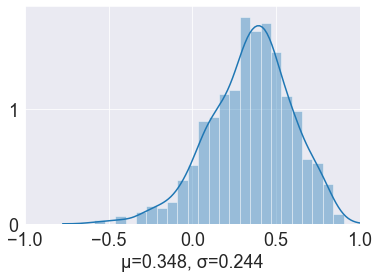

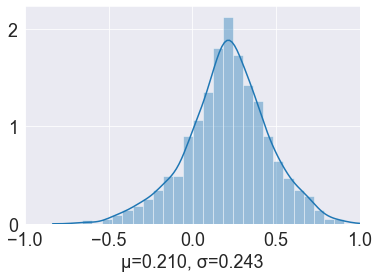

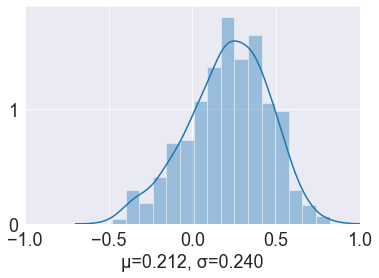

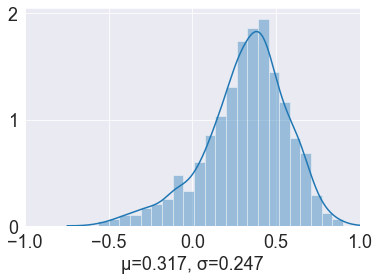

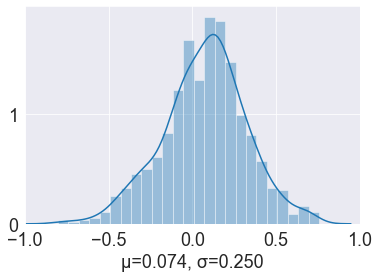

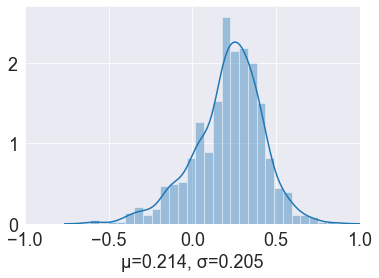

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 18})

table_contents = [
    (corr_by_words1, corr_by_words2),
    (corr_by_words3, corr_by_words4),
    (corr_by_words5, corr_by_words6),
]
    
for tidx, (corr_by_words_clse, corr_by_words_auth) in enumerate(table_contents):
    fig = plt.figure()
    x = corr_by_words_clse["corr"]
    ax = sns.distplot(x)
#     ax2 = ax.twinx()
#     sns.boxplot(x=x, ax=ax2)
#     ax2.set(ylim=(-1, 10))
#     plt.hist(x, bins=20)
    plt.xlim([-1, 1])
    plt.xlabel(f"μ={np.mean(x):.3f}, σ={np.std(x):.3f}")
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.savefig(f'Figures/task{tidx+1}-clse-corr.png', bbox_inches='tight', dpi=150)
# #     plt.show() 
    
    fig = plt.figure()
    x = corr_by_words_auth["corr"]
#     plt.hist(x, bins=20)
    sns.distplot(x)
    plt.xlabel(f"μ={np.mean(x):.3f}, σ={np.std(x):.3f}")
    plt.xlim([-1, 1])
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.savefig(f'Figures/task{tidx+1}-auth-corr.png', bbox_inches='tight', dpi=150)